In [1]:
import random
import time
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import heapq
import math

In [2]:
def generate_random_digraph(N, max_edges_per_vertex, edge_probability=0.3, weight_range=(1, 10)):
    """
    Generates a random weighted directed graph with N vertices, ensuring that no vertex has more than max_edges_per_vertex edges.
    
    :param N: Number of vertices
    :param max_edges_per_vertex: Maximum number of outgoing edges per vertex
    :param edge_probability: Probability of an edge existing between two nodes
    :param weight_range: Tuple representing the range of edge weights (min, max)
    :return: A NetworkX directed graph
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(N))
    
    for i in range(N):
        possible_targets = list(set(range(N)) - {i})  # Exclude self-loops
        random.shuffle(possible_targets)
        num_edges = min(max_edges_per_vertex, len(possible_targets))  # Limit max edges per vertex
        
        for j in possible_targets[:num_edges]:
            if random.random() < edge_probability:
                weight = random.randint(*weight_range)
                G.add_edge(i, j, weight=weight)
    
    return G

def draw_graph(G):
    """Draws the directed weighted graph."""
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges}
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, edge_color='gray', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

def export_to_excel(G, N):
    """Exports the graph's edges and weights to an Excel file named after the number of vertices."""
    filename = f"graph_{N}.xlsx"
    df = pd.DataFrame([(u, v, G[u][v]['weight']) for u, v in G.edges], columns=["Source", "Target", "Weight"])
    df.to_excel(filename, index=False)
    print(f"Graph exported to {filename}")

def dijkstra_shortest_path(G, source, target):
    """Finds the shortest path between source and target using Dijkstra's algorithm."""
    start_time = time.time()
    try:
        path = nx.shortest_path(G, source=source, target=target, weight='weight', method='dijkstra')
        path_length = nx.shortest_path_length(G, source=source, target=target, weight='weight', method='dijkstra')
        end_time = time.time()
        
        print(f"Shortest path from {source} to {target}: {path} with total weight {path_length}")
        print(f"Nodes explored by Dijkstra: {len(path)}")
        print(f"Time taken by Dijkstra: {(end_time - start_time)*1000:.4f} ms")
        
        return path, path_length, end_time - start_time
    except nx.NetworkXNoPath:
        end_time = time.time()
        print(f"No path found from {source} to {target}.")
        return None, None, end_time - start_time

def euclidean_distance_heuristic(G, pos, node, target):
    """
    Calculates the Euclidean distance between two nodes based on their positions.
    This serves as a heuristic for A* algorithm.
    """
    return math.sqrt((pos[node][0] - pos[target][0])**2 + (pos[node][1] - pos[target][1])**2)

def manhattan_distance_heuristic(G, pos, node, target):
    """
    Calculates the Manhattan distance between two nodes based on their positions.
    This serves as an alternative heuristic for A* algorithm.
    """
    return abs(pos[node][0] - pos[target][0]) + abs(pos[node][1] - pos[target][1])

def a_star_shortest_path(G, source, target, heuristic_type="euclidean"):
    """
    Finds the shortest path between source and target using A* algorithm.
    
    :param G: NetworkX directed graph
    :param source: Source node
    :param target: Target node
    :param heuristic_type: Type of heuristic to use ("euclidean" or "manhattan")
    :return: Tuple containing (path, path_length, execution_time)
    """
    start_time = time.time()
    
    # Generate positions for all nodes (for heuristic calculation)
    pos = nx.spring_layout(G, seed=42)  # seed for reproducibility
    
    # Select the appropriate heuristic function
    if heuristic_type.lower() == "manhattan":
        heuristic_func = manhattan_distance_heuristic
        print("Using Manhattan distance heuristic")
    else:
        heuristic_func = euclidean_distance_heuristic
        print("Using Euclidean distance heuristic")
    
    # Priority queue for nodes to explore
    open_set = [(0, source, [source])]  # (f_score, node, path)
    heapq.heapify(open_set)
    
    # Closed set to keep track of visited nodes
    closed_set = set()
    
    # Cost from start to node
    g_score = {node: float('infinity') for node in G.nodes()}
    g_score[source] = 0
    
    # Number of nodes explored
    nodes_explored = 0
    
    while open_set:
        f_score, current, path = heapq.heappop(open_set)
        nodes_explored += 1
        
        if current == target:
            # Calculate total path weight
            path_length = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))
            end_time = time.time()
            
            print(f"A* found path from {source} to {target}: {path} with total weight {path_length}")
            print(f"Nodes explored by A*: {nodes_explored}")
            print(f"Time taken by A*: {(end_time - start_time)*1000:.4f} ms")
            
            return path, path_length, end_time - start_time
        
        if current in closed_set:
            continue
            
        closed_set.add(current)
        
        for neighbor in G.successors(current):
            if neighbor in closed_set:
                continue
                
            tentative_g_score = g_score[current] + G[current][neighbor]['weight']
            
            if tentative_g_score < g_score[neighbor]:
                g_score[neighbor] = tentative_g_score
                new_path = path + [neighbor]
                
                # Calculate f_score = g_score + heuristic
                h_score = heuristic_func(G, pos, neighbor, target)
                f_score = tentative_g_score + h_score
                
                heapq.heappush(open_set, (f_score, neighbor, new_path))
    
    end_time = time.time()
    print(f"No path found from {source} to {target}.")
    return None, None, end_time - start_time

def highlight_path_in_graph(G, path):
    """Draw the graph with the shortest path highlighted in red."""
    if not path:
        draw_graph(G)
        return
        
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges}
    
    # Draw the graph with all edges in gray
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, edge_color='gray', arrowsize=20)
    
    # Create a list of edges in the path
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    
    # Draw the path edges in red
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2.0, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title(f"Path: {' -> '.join(str(node) for node in path)}")
    plt.show()

def compare_algorithms(G, source, target):
    """
    Compare Dijkstra, A* with Euclidean heuristic, and A* with Manhattan heuristic.
    Prints performance metrics for each algorithm.
    """
    print("\n=== Algorithm Comparison ===")
    
    # Dijkstra's algorithm
    path_dijkstra, length_dijkstra, time_dijkstra = dijkstra_shortest_path(G, source, target)
    
    # A* with Euclidean heuristic
    path_astar_euclidean, length_astar_euclidean, time_astar_euclidean = a_star_shortest_path(G, source, target, "euclidean")
    
    # A* with Manhattan heuristic
    path_astar_manhattan, length_astar_manhattan, time_astar_manhattan = a_star_shortest_path(G, source, target, "manhattan")
    
    # Print summary
    print("\n=== Performance Summary ===")
    
    def print_algorithm_stats(name, path, length, time_taken):
        if path:
            print(f"{name}:")
            print(f"  Path length = {length}")
            print(f"  Execution time = {time_taken*1000:.4f} ms")
        else:
            print(f"{name}: No path found")
    
    print_algorithm_stats("Dijkstra's Algorithm", path_dijkstra, length_dijkstra, time_dijkstra)
    print_algorithm_stats("A* (Euclidean)", path_astar_euclidean, length_astar_euclidean, time_astar_euclidean)
    print_algorithm_stats("A* (Manhattan)", path_astar_manhattan, length_astar_manhattan, time_astar_manhattan)
    
    # Check if all algorithms found the same path length
    if path_dijkstra and path_astar_euclidean and path_astar_manhattan:
        if length_dijkstra == length_astar_euclidean == length_astar_manhattan:
            print("\nAll algorithms found paths with the same length.")
        else:
            print("\nWarning: Algorithms found paths with different lengths!")


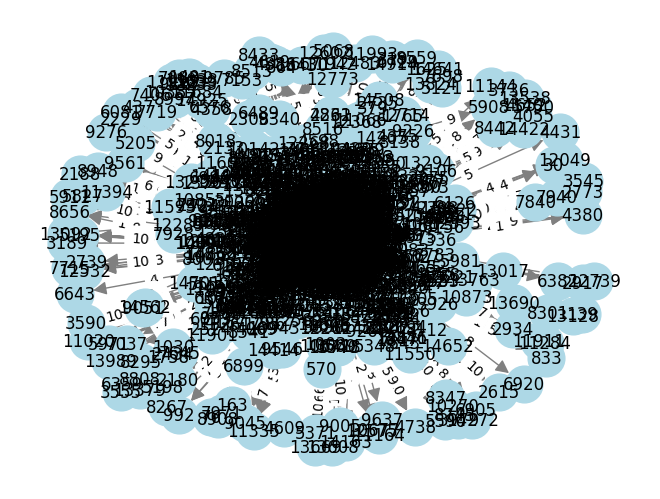

In [35]:
if __name__ == "__main__":
    N = int(input("Enter the number of vertices: "))
    max_edges_per_vertex = int(input("Enter the maximum number of edges per vertex: "))
    edge_probability = float(input("Enter the probability of edge creation (0-1): "))
    G = generate_random_digraph(N, max_edges_per_vertex, edge_probability)
    draw_graph(G)

In [ ]:
export_to_excel(G, N)


Graph exported to graph_15000.xlsx


In [41]:

source = int(input("Enter the source vertex for the algorithms: "))
target = int(input("Enter the target vertex for the algorithms: "))



In [42]:
algorithm = input("Choose algorithm (1 for Dijkstra, 2 for A* with Euclidean, 3 for A* with Manhattan, 4 to compare all): ")
   

In [45]:
if algorithm == "1":
    path, path_length, _ = dijkstra_shortest_path(G, source, target)
    if path:
        highlight_path_in_graph(G, path)
elif algorithm == "2":
    path, path_length, _ = a_star_shortest_path(G, source, target, "euclidean")
    if path:
        highlight_path_in_graph(G, path)
elif algorithm == "3":
    path, path_length, _ = a_star_shortest_path(G, source, target, "manhattan")
    if path:
        highlight_path_in_graph(G, path)
elif algorithm == "4":
    compare_algorithms(G, source, target)
    # Ask which path to visualize
    viz_choice = input("\nWhich algorithm's path would you like to visualize? (1=Dijkstra, 2=A* Euclidean, 3=A* Manhattan): ")
    if viz_choice == "1":
        path, _, _ = dijkstra_shortest_path(G, source, target)
    elif viz_choice == "2":
        path, _, _ = a_star_shortest_path(G, source, target, "euclidean")
    elif viz_choice == "3":
        path, _, _ = a_star_shortest_path(G, source, target, "manhattan")
    else:
        print("Invalid choice. No path will be visualized.")
        path = None
    
    if path:
        highlight_path_in_graph(G, path)
else:
    print("Invalid choice. Please run the program again.")


=== Algorithm Comparison ===
Shortest path from 3000 to 14000: [3000, 355, 10818, 701, 5069, 1213, 4147, 2685, 4745, 5449, 1761, 14000] with total weight 64
Nodes explored by Dijkstra: 12
Time taken by Dijkstra: 55.5205 ms
Using Euclidean distance heuristic
A* found path from 3000 to 14000: [3000, 355, 10818, 701, 5069, 1213, 4147, 2685, 4745, 5449, 1761, 14000] with total weight 64
Nodes explored by A*: 11995
Time taken by A*: 429734.3395 ms


KeyboardInterrupt: 

Shortest path from 3000 to 14000: [3000, 355, 10818, 701, 5069, 1213, 4147, 2685, 4745, 5449, 1761, 14000] with total weight 64
Nodes explored by Dijkstra: 12
Time taken by Dijkstra: 45.0613 ms


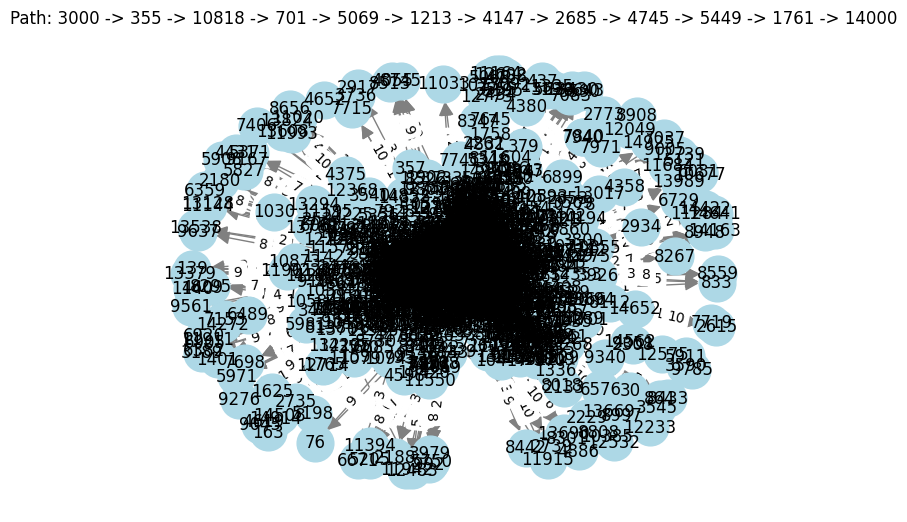

Execution time: 572.451908300005 seconds


In [44]:
start_time = time.perf_counter()

# Code to be timed
path, path_length, _ = dijkstra_shortest_path(G, source, target)
if path:
        highlight_path_in_graph(G, path)

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")